In [1]:
import os
import cv2
import math
import datetime
import numpy as np
from PIL import Image
from tqdm import tqdm
from enum import Enum
import functions as f
from patchify import patchify
from keras import backend as K
import matplotlib.pyplot as plt
from keras.layers import Rescaling
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from keras.models import Model, load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout

In [15]:
data_dir = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0"
batch_size = 32

In [3]:
print(f"Training data: {len(os.listdir(os.path.join(data_dir, 'train', 'train-org-img')))}")
print(f"Validation data: {len(os.listdir(os.path.join(data_dir, 'val', 'val-org-img')))}")
print(f"Test data: {len(os.listdir(os.path.join(data_dir, 'test', 'test-org-img')))}")

Training data: 1445
Validation data: 450
Test data: 448


In [25]:
def load_images_and_masks(data_dir, split="train"):
    image_list = []
    mask_list = []

    for file in tqdm(os.listdir(os.path.join(data_dir, f"{split}/{split}-org-img"))):
        if file.endswith(".jpg"): 
            image_path = os.path.join(data_dir,  f"{split}/{split}-org-img", file)
            mask_path = (os.path.join(data_dir,  f"{split}/{split}-label-img", file[:-4] + "_lab.png"))

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path)

            image_list.append(np.asarray(image))
            mask_list.append(np.asarray(mask))

    return image_list, mask_list


# X_train, Y_train = load_images_and_masks(f'{data_dir}/', "train")
X_val, Y_val = load_images_and_masks(f'{data_dir}/', "val")
# X_test, Y_test = load_images_and_masks(f'{data_dir}/', "test")

# print(f"Training data: {len(X_train)}")
print(f"Validation data: {len(X_val)}")
# print(f"Test data: {len(X_test)}")

100%|██████████| 450/450 [03:44<00:00,  2.00it/s]


Validation data: 450


Following is the source of color map used:
Source: https://github.com/farshadsafavi/BiseNetV2/blob/main/colors.txt

In [18]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

color_map = {
    "Background": [0, 0, 0],
    "Building-flooded": [255, 0, 0],
    "Building-non-flooded": [0, 255, 0],
    "Road-flooded": [0, 255, 120],
    "Road-non-flooded": [0, 0, 255],
    "Water": [255, 0, 255],
    "Tree": [70, 70, 70],
    "Vehicle": [102, 102, 156],
    "Pool": [190, 153, 153],
    "Grass": [180, 165, 180]
}

handles = [
    Rectangle((0, 0), 1, 1, color=np.array(c)/255) for n, c in color_map.items()
]
labels = [n for n, c in color_map.items()]

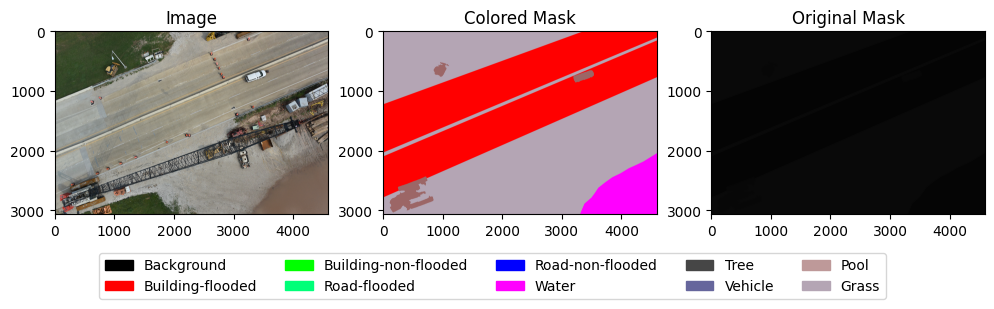

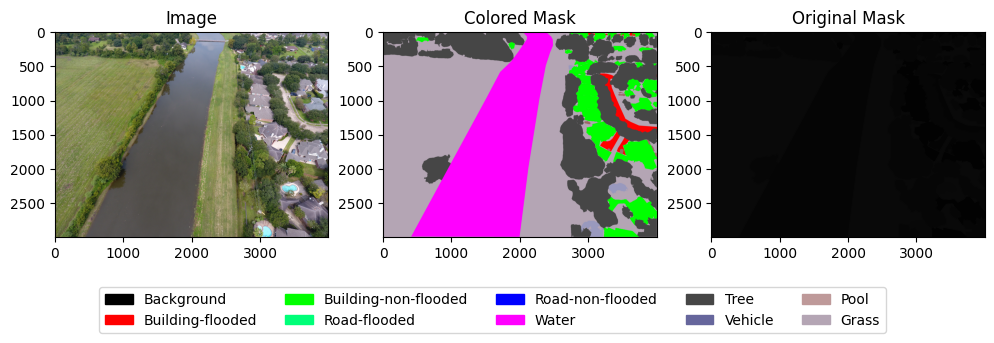

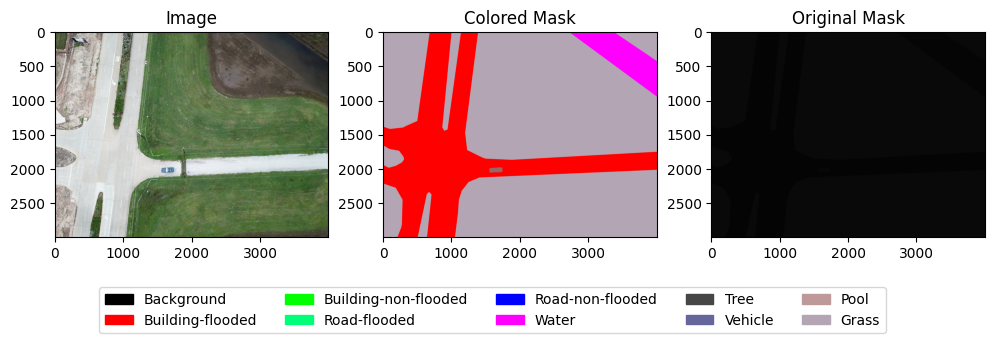

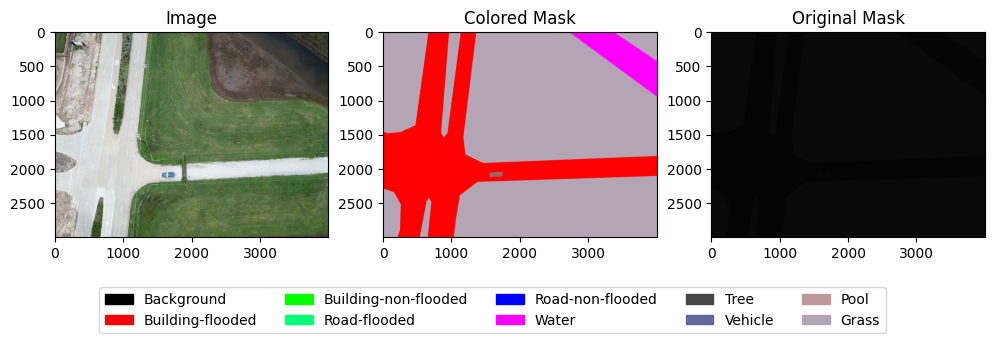

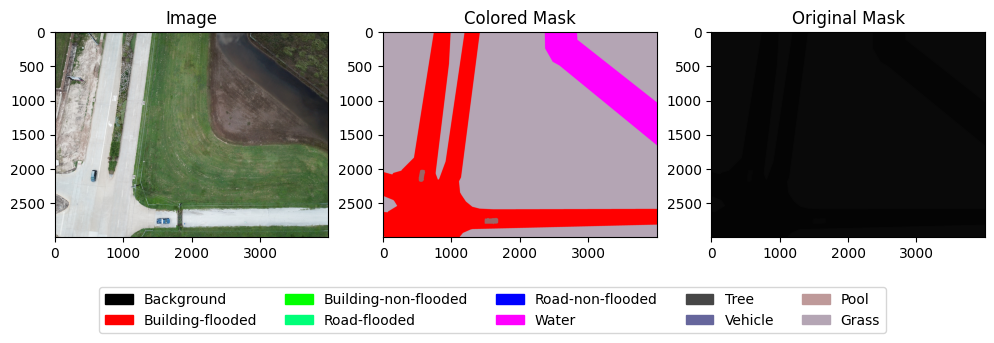

In [26]:
def display_images_with_masks(images, masks, class_map, color_map):
    for i in range(5):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title('Image')

        plt.subplot(1, 3, 2)
        mask_colored = np.zeros_like(images[i], dtype=np.uint8)
        for class_name, class_idx in class_map.items():
            color = color_map[class_name]
            mask_indices = np.where(masks[i] == class_idx)
            mask_colored[mask_indices[0], mask_indices[1], :] = color
        plt.imshow(cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB))
        plt.title('Colored Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(masks[i], cmap='viridis')
        plt.title('Original Mask')

        plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
        plt.show()

display_images_with_masks(X_val[10:], Y_val[10:], class_map, color_map)